# Milliken Moment Diagram Analysis

Importing necessary libraries

In [6]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append("..")
import magic_moment_method.vehicle_params as vehicle_params
import magic_moment_method.state_solver as state_solver
from magic_moment_method.solver_sweeper import solver_sweeper
import labellines

In [10]:
mesh = 31 # NOTE: MAKE SURE THIS IS ODD

# NOTE: guesstimation based from TTC on maximum tire saturation slip angle
sweep_range = {"body_slip": (-10 * np.pi / 180, 10 * np.pi / 180),
        "steered_angle" : (-20 * np.pi / 180, 20 * np.pi / 180),
        "velocity" : (3, 30),
        "torque_request": None,
        "is_left_diff_bias": (True, False)}

body_slip_sweep = np.linspace(sweep_range["body_slip"][0], sweep_range["body_slip"][1], mesh)
steered_angle_sweep = np.linspace(sweep_range["steered_angle"][0], sweep_range["steered_angle"][1], mesh)

sweep_values = {"velocity": [15], "body_slip":body_slip_sweep, "steered_angle":steered_angle_sweep,
                 "torque_request": [0], "is_left_diff_bias" : [True]}


vehicle = vehicle_params.Concept2023(motor_directory="vehicle_params/Eff228.csv")

df = solver_sweeper(vehicle, sweep_values)

tires = ["front_left", "front_right", "rear_left", "rear_right"]

961it [00:13, 73.69it/s]


Import generated points & filter garbage points

MMD Plot (Note - this really doesnt work when you are sweeping velocities and torque requests)

Text(0.5, 1.0, 'Milliken Moment Method \n Blue -> Discrete Steered Angle (deg); Red -> Discrete Body Slip (deg)')

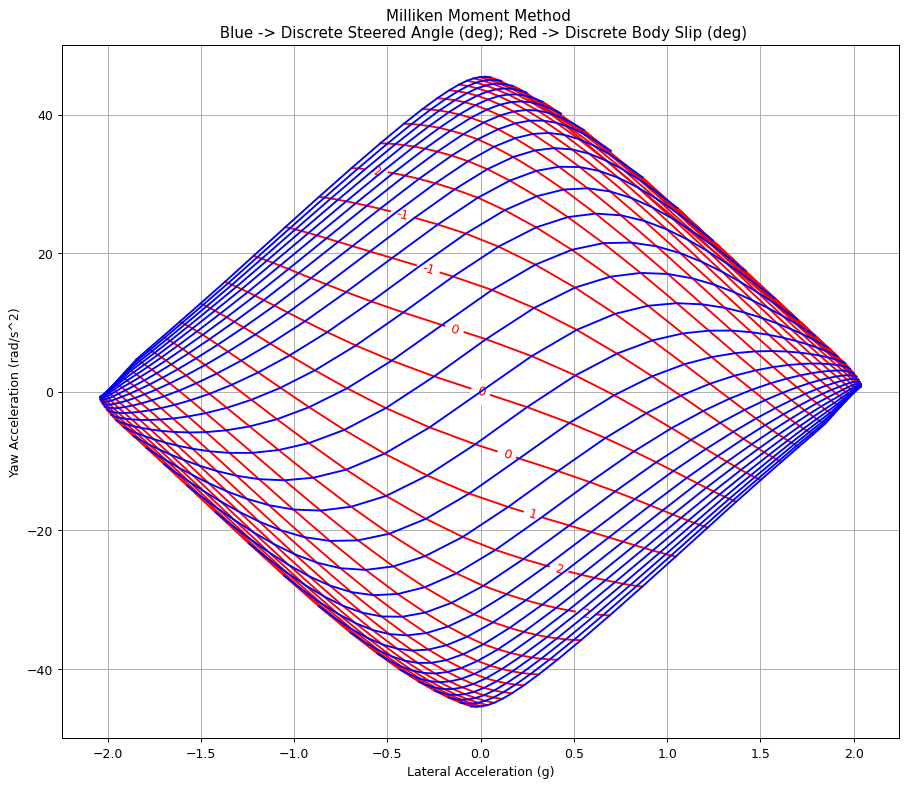

In [11]:
fig = plt.figure(figsize=(12, 10), dpi=90)
ax = fig.add_subplot(111)
mmm_df = df # df[abs(df["torque_request"]-0) < 0.01 ]
for x in mmm_df["body_slip"].unique():
    df2 = mmm_df[mmm_df["body_slip"] == x]    
    plt.plot(df2["vehicle_accelerations_NTB_1"]/9.81, df2["yaw_acceleration"], 'r', label = int(x*180/np.pi))
labellines.labelLines(plt.gca().get_lines(),zorder=2)

for x in mmm_df["steered_angle"].unique():
    df2 = mmm_df[(mmm_df["steered_angle"] == x)]
    plt.plot(df2["vehicle_accelerations_NTB_1"]/9.81, df2["yaw_acceleration"], 'b', label = int(x*180/np.pi))
#labellines.labelLines(plt.gca().get_lines(),zorder=2)

plt.grid()
plt.ylabel("Yaw Acceleration (rad/s^2)")
plt.xlabel("Lateral Acceleration (g)")
plt.title("Milliken Moment Method \n Blue -> Discrete Steered Angle (deg); Red -> Discrete Body Slip (deg)")

NameError: name 'ConvexHull' is not defined

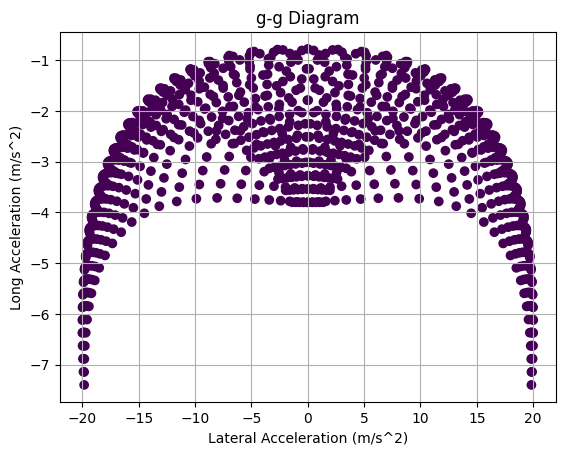

In [9]:
plt.scatter(df["vehicle_accelerations_NTB_1"], df["vehicle_accelerations_NTB_0"] , c=df["torque_request"],cmap="viridis")
plt.title("g-g Diagram")
plt.ylabel("Long Acceleration (m/s^2)")
plt.xlabel("Lateral Acceleration (m/s^2)")
plt.grid()

points = df[["vehicle_accelerations_NTB_1","vehicle_accelerations_NTB_0"]].to_numpy()
hull = ConvexHull(points)
x = np.transpose(points)
plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')
#plt.scatter(x[0], x[1])
plt.show()
new_df = df.iloc[hull.vertices]

In [ ]:
plt.scatter(new_df["torque_request"], new_df["vehicle_accelerations_NTB_0"], s=10)
plt.grid()

In [ ]:
plt.scatter(df["torque_request"], df["vehicle_accelerations_NTB_1"], s=10)
plt.grid()

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(16, 6), dpi=80)

axs[0].scatter(df['vehicle_accelerations_NTB_1'], df['roll'] * (180 / np.pi))
axs[0].set_xlabel("Lateral Acceleration (m/s^2)")
axs[0].set_ylabel('Roll Angle (Degrees)')
axs[0].set_title("Roll Angle vs Lateral Accel")
axs[0].grid()

axs[1].scatter(df['vehicle_accelerations_NTB_1'], df['pitch'] * (180 / np.pi))
axs[1].set_xlabel("Lateral Acceleration (m/s^2)")
axs[1].set_ylabel('Pitch Angle (Degrees)')
axs[1].set_title("Pitch Angle vs Lateral Accel")
axs[1].grid()

axs[2].scatter(df['vehicle_accelerations_NTB_1'], df['heave']/.0254)
axs[2].set_xlabel("Lateral Acceleration (m/s^2)")
axs[2].set_ylabel('Heave (in)')
axs[2].set_title("Heave vs Lateral Accel")
axs[2].grid()

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(16, 6), dpi=80)

for tire in tires:
    axs[0].scatter(df["vehicle_accelerations_NTB_1"], df[f"{tire}_tire_f_roll"], label = tire)
axs[0].set_title("Roll Spring - Normal Force vs Lateral Accel")
axs[0].grid()
axs[0].set_ylabel("Normal Force Roll (N)")
axs[0].set_xlabel("Lateral Acceleration (m/s^2)")
axs[0].legend()

for tire in tires:
    axs[1].scatter(df["vehicle_accelerations_NTB_1"], df[f"{tire}_tire_f_heave"], label = tire)
axs[1].set_title("Heave Spring- Normal Force vs Lateral Accel")
axs[1].grid()
axs[1].set_ylabel("Heave Normal Force (N)")
axs[1].set_xlabel("Lateral Acceleration (m/s^2)")
axs[1].legend()

for tire in tires:
    axs[2].scatter(df["vehicle_accelerations_NTB_1"], df[f"{tire}_tire_f_pitch"], label = tire)
axs[2].set_title("Pitch Spring - Normal Force vs Lateral Accel")
axs[2].grid()
axs[2].set_ylabel("Pitch Normal Force (N)")
axs[2].set_xlabel("Lateral Acceleration (m/s^2)")
axs[2].legend()

In [ ]:
fig, axs = plt.subplots(1,4,figsize=(16, 6), dpi=80)

axs[0].scatter(df['vehicle_accelerations_NTB_1'], df['rear_right_tire_slip_angle'] * (180 / np.pi), label='Rear Right')
axs[0].scatter(df['vehicle_accelerations_NTB_1'], df['rear_left_tire_slip_angle'] * (180 / np.pi), label='Rear Left')
axs[0].scatter(df['vehicle_accelerations_NTB_1'], df['front_right_tire_slip_angle'] * (180 / np.pi), label='Front Right')
axs[0].scatter(df['vehicle_accelerations_NTB_1'], df['front_left_tire_slip_angle'] * (180 / np.pi), label='Front Left')
axs[0].legend()
axs[0].set_xlabel("Lateral Acceleration (m/s^2)")
axs[0].set_ylabel('Wheel Slip Angle (Degrees)')
axs[0].set_title("Slip Angle vs Lateral Accel")
axs[0].grid()

axs[1].scatter(df['vehicle_accelerations_NTB_1'], df['rear_right_tire_inclination_angle'] * (180 / np.pi), label='Rear Right')
axs[1].scatter(df['vehicle_accelerations_NTB_1'], df['rear_left_tire_inclination_angle'] * (180 / np.pi), label='Rear Left')
axs[1].scatter(df['vehicle_accelerations_NTB_1'], df['front_right_tire_inclination_angle'] * (180 / np.pi), label='Front Right')
axs[1].scatter(df['vehicle_accelerations_NTB_1'], df['front_left_tire_inclination_angle'] * (180 / np.pi), label='Front Left')
axs[1].legend()
axs[1].set_xlabel("Lateral Acceleration (m/s^2)")
axs[1].set_ylabel('Wheel Inclination Angle (Degrees)')
axs[1].set_title("IA Angle vs Lateral Accel")
axs[1].grid()

axs[2].scatter(df['vehicle_accelerations_NTB_1'], df['rear_right_tire_velocity_0'], label='Rear Right')
axs[2].scatter(df['vehicle_accelerations_NTB_1'], df['rear_left_tire_velocity_0'], label='Rear Left')
axs[2].scatter(df['vehicle_accelerations_NTB_1'], df['front_right_tire_velocity_0'], label='Front Right')
axs[2].scatter(df['vehicle_accelerations_NTB_1'], df['front_left_tire_velocity_0'], label='Front Left')
axs[2].legend()
axs[2].set_xlabel("Lateral Acceleration (m/s^2)")
axs[2].set_ylabel('Tire Velocity (m/s)')
axs[2].set_title("Tire Velocity vs Lateral Accel")
axs[2].grid()

axs[3].scatter(df['vehicle_accelerations_NTB_1'], df['rear_right_tire_slip_ratio'], label='Rear Right')
axs[3].scatter(df['vehicle_accelerations_NTB_1'], df['rear_left_tire_slip_ratio'], label='Rear Left')
axs[3].scatter(df['vehicle_accelerations_NTB_1'], df['front_right_tire_slip_ratio'], label='Front Right')
axs[3].scatter(df['vehicle_accelerations_NTB_1'], df['front_left_tire_slip_ratio'], label='Front Left')
axs[3].legend()
axs[3].set_xlabel("Lateral Acceleration (m/s^2)")
axs[3].set_ylabel('Tire Slip Ratio (%)')
axs[3].set_title("Tire Slip Ratio vs Lateral Accel")
axs[3].grid()

In [ ]:
temp_df = df[abs(df["vehicle_turn_radius"]) < 1000]
plt.scatter(temp_df["vehicle_accelerations_NTB_1"],temp_df["vehicle_turn_radius"])
plt.grid()
plt.title("Turn Radius vs Lateral Accel (constant velocity)")

In [ ]:
for x in mmm_df["steered_angle"].unique():
    if True:#x == 0:
        df2 = mmm_df[(mmm_df["steered_angle"] == x)]
        plt.plot(df2["body_slip"] * 180/math.pi, df2["vehicle_yaw_moment"]/9.81)
plt.xlim([0, 13])
plt.title("Stability Index - Yaw Moment vs Body Slip (Steered Angle sweep)")
plt.ylabel("Yaw Moment (Nm)")
plt.xlabel("Body Slip (degrees)")
plt.grid(True)
plt.show()

In [ ]:
import magic_moment_method.vehicle_params as vehicle_params
import magic_moment_method.state_solver as state_solver
vehicle = state_solver.Vehicle(vehicle_params.EasyDriver())
slip_angles = np.linspace(-30, 30, 1000)
s = vehicle.suspension
for normal_force in np.linspace(10, 2000, 10):
    output_force = [vehicle.suspension._Suspension__tires.front_right.lateral_pacejka(0, normal_force, y/180*np.pi) for y in slip_angles]
    plt.plot(slip_angles, output_force)
plt.grid()
plt.title("Front Tire - Lateral Fit")

In [ ]:
slip_ratios = np.linspace(-1, 1, 15)
normal_loads = np.array([500, 750, 100])
colors = np.array(["r", "g", "b"])
for index, load in enumerate(normal_loads):
    output = []
    for slip_ratio in slip_ratios:
        for slip_angle in slip_ratios:
            comstock_output = s._Suspension__tires.front_left.get_comstock_forces(slip_ratio, slip_angle, load, 0)
            output.append([comstock_output[0], comstock_output[1]])
            plt.scatter(comstock_output[0], comstock_output[1], c= colors[index])
plt.ylabel("Lateral Acceleration (m/s^2)")
plt.xlabel("Long Acceleration (m/s^2)")
plt.title("Long vs Lateral")
plt.legend(normal_loads)
plt.show()

In [ ]:
#temp_df = df[abs(df["vehicle_turn_radius"]) < 1000]
plt.scatter(df["vehicle_accelerations_NTB_1"],df["front_right_tire_disp"])
plt.scatter(df["vehicle_accelerations_NTB_1"],df["front_left_tire_disp"])
plt.scatter(df["vehicle_accelerations_NTB_1"],df["rear_right_tire_disp"])
plt.scatter(df["vehicle_accelerations_NTB_1"],df["rear_left_tire_disp"])
plt.grid()

In [ ]:
plt.scatter(df["vehicle_accelerations_NTB_1"],df["aero_forces_0"], label = "drag")
plt.scatter(df["vehicle_accelerations_NTB_1"],df["aero_forces_1"], label = "sideforce")
plt.scatter(df["vehicle_accelerations_NTB_1"],df["aero_forces_2"], label = "downforce")
plt.legend()
plt.grid()
plt.ylabel("Force (N)")
plt.xlabel("Lateral Acceleration (m/s^2)")

In [ ]:
plt.scatter(df["body_slip"]*180/np.pi,df["aero_forces_1"], label = "sideforce")
plt.grid()
plt.ylabel("Side Force (N)")
plt.xlabel("Body Slip (degs)")

In [ ]:
cg_heights = [14, 12, 10, 8, 6]
lateral_forces = [4134, 4300, 4475, 4650, 4816]

plt.scatter(cg_heights, lateral_forces)
plt.grid()
plt.title("Total Lateral Forces vs CG Height (700 lb car, 5 degrees steering, -3 degrees body slip)")
plt.ylabel("Total Lateral Forces from Tires (N)")
plt.xlabel("CG Height (in)")